# pyslim spatial tutorial with retained individuals

In [1]:
# this makes plots interactive, which i was having some fun with (eg spinning 3d plots around)
# %matplotlib widget

Load required modules and give required paths

In [2]:
import pyslim, tskit #tree sequence tools
from IPython.display import SVG #for displaying trees in svg format
import matplotlib.pyplot as plt #plotting
import numpy as np #lots of stuff
import matplotlib.cm as cm #color maps

datadir = 'data/'

First we borrow the SLiM script from the spatial vignette (https://pyslim.readthedocs.io/en/latest/vignette_space.html), with a few small changes:
1) discrete generations
2) remember ancestors if they remain in the final tree sequence (whether they are coalescent nodes or not (unary))

We then run this simulation with SLiM (see the 'spatial_sim.slim' file) and load the resulting tree sequence here

In [3]:
ts = pyslim.load(datadir + 'spatial_sim.trees')

Print some info on the tree sequence

In [4]:
ts

How many individuals are alive in the present-day?

In [5]:
alive = ts.individuals_alive_at(0)
len(alive)

333

How many genetic ancestors were there t generations ago?

In [6]:
t = 100
ancestors = ts.individuals_alive_at(t)
len(ancestors)

12

Now let's take a sample of n haploid genomes from the present day

In [7]:
n = 3
np.random.seed(6)
sampled_nodes = np.random.choice(ts.samples(), n, replace=False)

Simplify the tree sequence to these samples, while keeping all ancestors (both coalescences and unary nodes)

In [8]:
sts = ts.simplify(sampled_nodes, keep_unary=True)
sts

which we can take a look at after dropping the unary nodes (so we only remember ancestors if they occur at coalescent points)

In [9]:
stsnu = ts.simplify(sampled_nodes, keep_unary=False)
stsnu

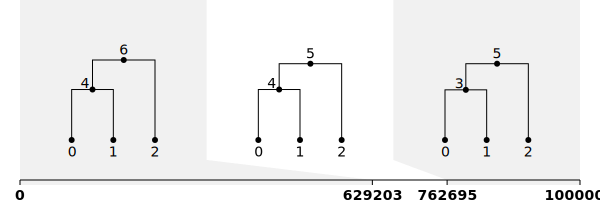

In [10]:
SVG(stsnu.draw_svg())

Now let's visualize one of these trees in space

if we only care about the coalescent events

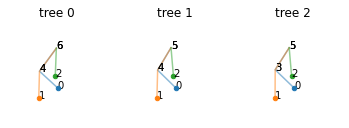

In [11]:
treeseq = stsnu #tree sequence of interest
trees = [i for i in range(treeseq.num_trees)] #which trees to plot

cmap = plt.get_cmap('tab10') #colors
fig = plt.figure() #start the figure

# loop over trees of interest
for i in trees:
    
    tree = treeseq.at_index(i) #get the current tree
#     maxtime = tree.time(tree.root) #time to go back to
    maxtime = max([tree.tmrca(i,j) for i in sts.samples() for j in sts.samples()[:i]]) #go back to the most recent common ancestor

    ax = fig.add_subplot(1, treeseq.num_trees, i+1, projection='3d') #set up the 3D axis

    # loop over samples of interest
    for j,node in enumerate(treeseq.samples()): 

        xs = [] #list for x locations
        ys = [] #list for y locations
        times = [] #list for times (z axis of our 3D plot)

        # get location of sample
        ind = treeseq.individual(treeseq.node(node).individual) #individual containing the node of interest
        x,y = ind.location[:2] #location of individual
        t = ind.time #generation that individual was alive
        xs.append(x) #its x location
        ys.append(y) #its y location
        times.append(t) #its time
        ax.scatter(x, y, 1, color=cmap(j), alpha=1, marker='o', s=20) #plot this point
        ax.text(x,y,1,node) #add node number as label

        # now move up this lineage to maxtime, getting locations of ancestors
        # note this is redundant since lineages will coalesce (so we'll trace lineages as many times as they have descendants)
        while t < maxtime-1: #while we're not yet at the max time
            node = tree.get_parent(node) #get the parent node of our current sample node

            ind = treeseq.individual(treeseq.node(node).individual) #individual the parent node was in
            x,y = ind.location[:2] #location of the parent
            t = ind.time #time the parent was alive
            xs.append(x)
            ys.append(y)
            times.append(t)
            ax.text(x,y,t,node)
            # now we'll repeat this, appending to our lists (xs, ys, times), finding the parent of the parent, then the parent of that parent, ... until we get to the max time

        # now plot the information we just collected in this loop: the locations of all individuals in this lineage
        ax.plot(xs, ys, times, color=cmap(j), alpha=0.5) 

    ax.set_axis_off() #drop the axis lines and labels etc for a clean plot
    ax.set_xlim(0,10) #set x limits
    ax.set_ylim(0,10) #set y limits
    ax.set_xlabel('x') #x axis label (if set_axis is not off)
    ax.set_ylabel('y') #y axis label (if set_axis is not off)
    ax.set_zlabel('time') #z axis label (if set_axis is not off)
    ax.set_title('tree %d' %i) #title as tree index
    
plt.show() #show what we did!

or if we care about the unary nodes too

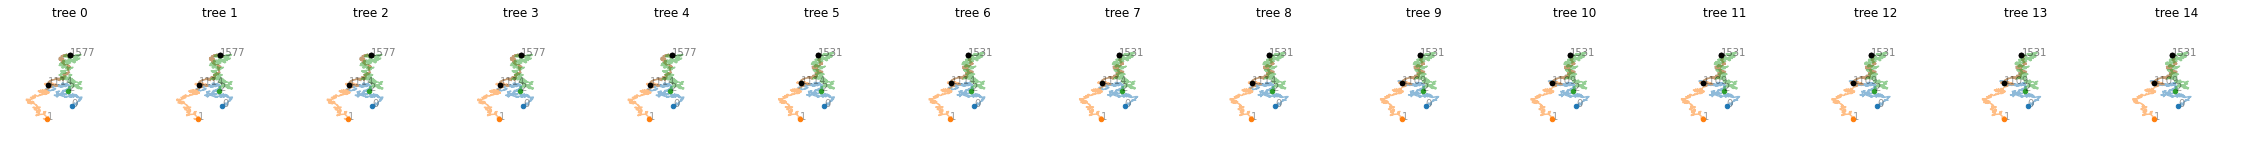

In [12]:
treeseq = sts #tree sequence of interest
trees = [i for i in range(treeseq.num_trees)] #which trees to plot

cmap = plt.get_cmap('tab10')
fig = plt.figure(figsize=(40,5))

# loop over trees of interest
for i in trees:
    
    tree = treeseq.at_index(i)
#     maxtime = tree.time(tree.root) #time to go back to
    maxtime = max([tree.tmrca(i,j) for i in sts.samples() for j in sts.samples()[:i]]) + 1 #tmrca

    ax = fig.add_subplot(1, treeseq.num_trees, i+1, projection='3d')

    # loop over samples of interest
    for j,node in enumerate(treeseq.samples()): 

        xs = []
        ys = []
        times = []

        # get location of sample
        ind = treeseq.individual(treeseq.node(node).individual)
        x,y = ind.location[:2]
        t = ind.time
        xs.append(x)
        ys.append(y)
        times.append(t)
        ax.scatter(x, y, 1, color=cmap(j), alpha=1, marker='o', s=20)
        ax.text(x,y,1,node, alpha=0.4, color='k')

        # now move up this lineage to maxtime, getting locations of ancestors
        # note this is redundant since lineages will coalesce
        while t < maxtime-1:
            node = tree.get_parent(node)

            ind = treeseq.individual(treeseq.node(node).individual)
            x,y = ind.location[:2]
            t = ind.time
            xs.append(x)
            ys.append(y)
            times.append(t)
            if len(tree.get_children(node)) > 1:
                ax.scatter(x,y,t,color='k',marker='o',s=20)
                ax.text(x,y,t,node, alpha=0.2)

        # plot this lineage
        ax.plot(xs, ys, times, color=cmap(j), alpha=0.5)

    ax.set_axis_off()
    ax.set_xlim(0,10)
    ax.set_ylim(0,10)
    ax.set_title('tree %d' %i)
    
plt.show()